# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [2]:
# Are we using a GPU
!nvidia-smi

Tue Apr  1 20:50:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Downloading and becoming one with data

In [3]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Dowload data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-04-01 20:50:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.6MB/s    in 8.1s    

2025-04-01 20:50:58 (19.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Wlak through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories abd {len(filenames)} images in '{dirpath}'.")

There are 2 directories abd 0 images in '10_food_classes_10_percent'.
There are 10 directories abd 0 images in '10_food_classes_10_percent/train'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories abd 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories abd 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images: ")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callback are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Creat tendorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d=%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating model using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layer are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the tensorFlow hub page and sorting for image classification, we found the following feature vector model link: tensorflow/efficientnet/tensorFlow2/b0-feature-vector

In [6]:


# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [7]:
# Set environment variable to use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Install compatible versions of TensorFlow, TensorFlow Hub, and Keras
!pip install tensorflow==2.15.0 tensorflow-hub==0.16.1 keras==2.15.0

# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, defualt 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

### Creating abd testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [10]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiments logs here
                                                                         experiment_name="resnet50V2")])
                                                                         # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250401=205316
Epoch 1/5
 2/24 [=>............................] - ETA: 1:04 - loss: 2.5355 - accuracy: 0.0938

KeyboardInterrupt: 

Wow!

That is incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
# Let's create a function to plot our loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_accuracy, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [16]:
# Create efficientNetB0 feature model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 tensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit Efficientnet model to 10% training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of trainign data
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20250401=205843
Epoch 1/5
24/24 [==============================] - 144s 6s/step - loss: 1.9955 - accuracy: 0.3293 - val_loss: 1.5400 - val_accuracy: 0.6008
Epoch 2/5
24/24 [==============================] - 129s 6s/step - loss: 1.3155 - accuracy: 0.6960 - val_loss: 1.1375 - val_accuracy: 0.7040
Epoch 3/5
24/24 [==============================] - 128s 6s/step - loss: 1.0121 - accuracy: 0.7600 - val_loss: 0.9534 - val_accuracy: 0.7456
Epoch 4/5
24/24 [==============================] - 131s 6s/step - loss: 0.8414 - accuracy: 0.8067 - val_loss: 0.8573 - val_accuracy: 0.7580
Epoch 5/5
24/24 [==============================] - 129s 6s/step - loss: 0.7338 - accuracy: 0.8373 - val_loss: 0.7981 - val_accuracy: 0.7704


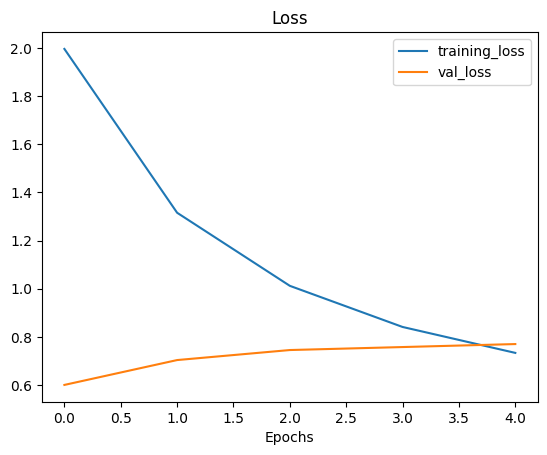

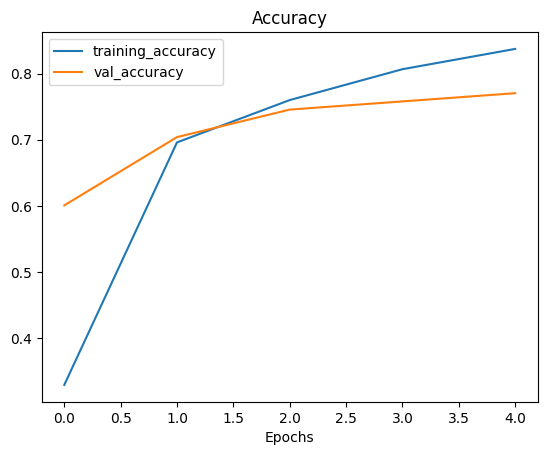

In [17]:
plot_loss_curves(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________
